### **Creating the directories for Training and Testing Data**

In [ ]:
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import cv2
import os
from PIL import Image

test_zip_file_path = "/content/marker_images_test.zip"
test_data_dir = "/content/marker_images_test"

with zipfile.ZipFile(test_zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(test_data_dir )


train_zip_file_path = "/content/marker_images_train.zip"
train_data_dir  = "/content/marker_images_train"

with zipfile.ZipFile(train_zip_file_path , 'r') as zip_ref:
    zip_ref.extractall(train_data_dir )


### **Data Loading**

In [ ]:
def load_data(data_dir):
    images = []
    labels = []
    for folder_name in os.listdir(data_dir):
        test_folder_path = os.path.join(data_dir, folder_name)
        if os.path.isdir(test_folder_path):
            for subfolder_name in os.listdir(test_folder_path):
                subfolder_path = os.path.join(test_folder_path, subfolder_name)
                if os.path.isdir(subfolder_path):
                    for sub_subfolder_name in os.listdir(subfolder_path):
                        sub_subfolder_path = os.path.join(subfolder_path, sub_subfolder_name)
                        if os.path.isdir(sub_subfolder_path):
                            image_files = [file for file in os.listdir(sub_subfolder_path) if file.endswith('.png')]
                            if len(image_files) != 2:
                                continue
                            img1 = cv2.imread(os.path.join(sub_subfolder_path, image_files[0]))
                            img2 = cv2.imread(os.path.join(sub_subfolder_path, image_files[1]))
                            if img1 is None or img2 is None:
                                continue

                            images.append((img1, img2))

                            label_file_path = None
                            for file in os.listdir(sub_subfolder_path):
                                if file.endswith('.txt'):
                                    label_file_path = os.path.join(sub_subfolder_path, file)
                                    break
                            if label_file_path is None or not os.path.exists(label_file_path):
                                continue

                            with open(label_file_path, 'r') as file:
                                line_labels = []
                                for line in file:
                                    line_labels.append(float(line.strip()))
                            labels.append(line_labels)

    return np.array(images), np.array(labels)



In [ ]:
test_data_directory = "/content/marker_images_test"
test_images, test_labels = load_data(test_data_directory)

In [ ]:
train_data_directory = "/content/marker_images_train"
train_images, train_labels = load_data(train_data_directory)

In [ ]:
print('Shape of train_images:', train_images.shape)
print('Shape of train_labels:', train_labels.shape)
print('Shape of test_images:', test_images.shape)
print('Shape of test_labels:', test_labels.shape)


Shape of train_images: (1324, 2, 640, 640, 3)
Shape of train_labels: (1324, 2)
Shape of test_images: (1316, 2, 640, 640, 3)
Shape of test_labels: (1316, 2)


### **Dataset Preparation to be fed to the network**


In [ ]:
train_dataset = TensorDataset(torch.from_numpy(train_images), torch.from_numpy(train_labels))
test_dataset = TensorDataset(torch.from_numpy(test_images), torch.from_numpy(test_labels))

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### **Modified ResNet18 architecture**

1. The final fully connected layer has been replaced with an MLP
2. The forward method has been modified to process two input images separately feeding them to the designed network , concatenate their features, and pass them through the final MLP for delta x and delta y prediction.

In [ ]:
class BuildingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(BuildingBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)

        return x

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        # First Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self.create_layer(64, 64, stride=1)
        self.layer2 = self.create_layer(64, 128, stride=2)
        self.layer3 = self.create_layer(128, 256, stride=2)
        self.layer4 = self.create_layer(256, 512, stride=2)

        # Final Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # MLP for regression
        self.mlp = nn.Sequential(
            nn.Linear(512 * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def create_layer(self, in_channels, out_channels, stride):
        identity_downsample = None

        if stride != 1:
            identity_downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(out_channels)
            )

        return nn.Sequential(
            BuildingBlock(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride),
            BuildingBlock(out_channels, out_channels)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # rearranging the dimensions of the tensor
        # to match the expected input format for the ResNet (batch, channels, height, width).
        x1 = x[:, 0, ...].permute(0, 3, 1, 2)
        x2 = x[:, 1, ...].permute(0, 3, 1, 2)


        x1 = self.relu(self.bn1(self.conv1(x1)))
        x1 = self.maxpool(x1)

        x2 = self.relu(self.bn1(self.conv1(x2)))
        x2 = self.maxpool(x2)

        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = self.layer3(x1)
        x1 = self.layer4(x1)

        x2 = self.layer1(x2)
        x2 = self.layer2(x2)
        x2 = self.layer3(x2)
        x2 = self.layer4(x2)


        x = torch.cat((x1, x2), dim=1)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.mlp(x)

        return x

### **Model Training and Evaluation**

In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.float().to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(train_loader.dataset)

def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.float().to(device), labels.float().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
    return running_loss / len(test_loader.dataset)


Epoch [1/10], Train Loss: 0.0025, Test Loss: 0.0013
Epoch [2/10], Train Loss: 0.0005, Test Loss: 0.0039
Epoch [3/10], Train Loss: 0.0005, Test Loss: 0.0012
Epoch [4/10], Train Loss: 0.0003, Test Loss: 0.0008
Epoch [5/10], Train Loss: 0.0002, Test Loss: 0.0031
Epoch [6/10], Train Loss: 0.0002, Test Loss: 0.0017
Epoch [7/10], Train Loss: 0.0001, Test Loss: 0.0010
Epoch [8/10], Train Loss: 0.0001, Test Loss: 0.0010
Epoch [9/10], Train Loss: 0.0001, Test Loss: 0.0010
Epoch [10/10], Train Loss: 0.0001, Test Loss: 0.0010


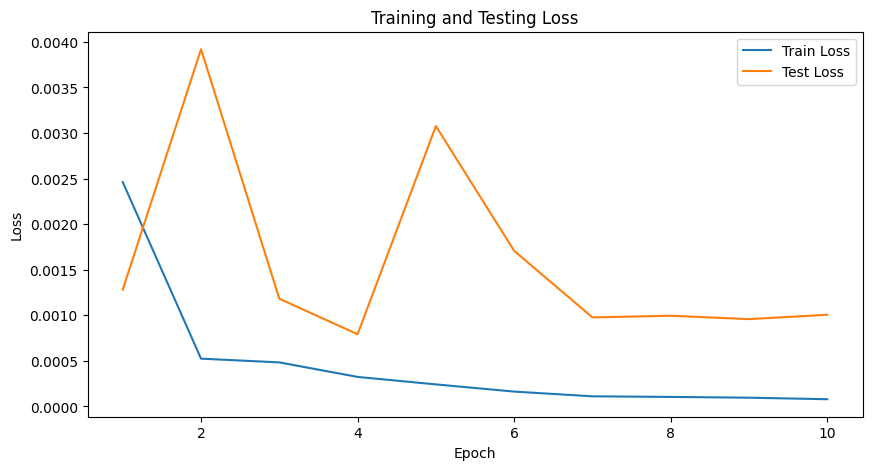

In [ ]:
import matplotlib.pyplot as plt


model = ResNet18()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss = test(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
